In [1]:
import os
import random
import numpy as np

####*IMPORANT*: Have to do this line *before* importing tensorflow
seed = 812
os.environ['PYTHONHASHSEED']=str(seed)

def reset_random_seeds(seed):
    os.environ['PYTHONHASHSEED']=str(seed)
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    keras.utils.set_random_seed(seed)
    
import cv2
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from keras import backend as K

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.applications import EfficientNetV2B3
from tensorflow.keras.layers import Input, Dense, Conv2D, Activation, MaxPooling2D, GlobalAveragePooling2D, Flatten
from tensorflow.keras.layers import Dropout, BatchNormalization, LayerNormalization
from tensorflow.keras.layers import Layer, Reshape, Concatenate, Multiply, Average, Add

from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()

import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
reset_random_seeds(seed)

In [2]:
# Task Name
task_name = " ACAN for COVID-19 from Chest CT Scan Images" 

# Desired image dimensions
IMAGE_SIZE = (256, 256)

#List of categories, types & grades
labels = ['Normal', 'COVID']

#Autotune
AUTOTUNE = tf.data.AUTOTUNE

#Batch Size
BATCH_SIZE = 64

In [3]:
# Auxiliary function for data distribution visualization
def data_visualization(classes, data):
    """
    Vizualize the distribution of the dataset.
  
    This function presents the number of samples each category has
    through a bar plot.

    Args:
        classes (list): List of the emotion-categories
        data (list): List of the number of images per category 
 
    Returns:
        No value
    """

    fig, ax = plt.subplots(figsize=(9, 5))
    ax.bar(classes, data)
    ax.set(title="Dataset's distribution for each class")
    ax.set(xlabel="Classes", ylabel="#Images");
    ax.grid()


def load_data(data_path, image_size):
    """
    Load the dataset to the memory.
  
    This function takes a data path and loads all images (along with their
    corresponding labels) as numpy arrays per category to the memory.
    Subsequently, the labels are one-hot encoded. Before the images, labels
    are returned, the distribution of the dataset is presented.

    Args:
        data_path (str): The path of the dataset's whereabouts
   
    Returns:
        data (numpy.ndarray): The images of the dataset
        labels (numpy.ndarray): The labels of each image
    """

    subfolders_ck = os.listdir(data_path)

    print("[INFO] Dataset Loading...\n")

    img_data_list=[]
    labels_list = []
    num_images_per_class = []

    for category in subfolders_ck:
        if '.csv' in category:
            continue
        img_list=os.listdir(data_path +'/'+ category)
        
        print('Loading :', len(img_list), 'images of category: ', category)
        for img in img_list:
            # Load an image from this path
            pixels=cv2.imread(data_path + '/'+ category + '/'+ img )
            pixels = cv2.cvtColor(pixels, cv2.COLOR_BGR2RGB)
            face_array=cv2.resize(pixels, (image_size[0],image_size[1]), fx=1, fy=1,interpolation = cv2.INTER_CUBIC)        
            img_data_list.append(face_array)          
            labels_list.append(category)
        num_images_per_class.append(len(img_list))

    le = LabelEncoder()
    labels = le.fit_transform(labels_list)
    labels = to_categorical(labels)
    data = np.array(img_data_list)
    
    #data_visualization(subfolders_ck, num_images_per_class)

    # Dataset Summary
    print("\nTotal number of uploaded data: ", data.shape[0],
          ", with data shape", (data.shape[1],data.shape[2],data.shape[3]))

    return data, labels

In [5]:
image_size = (IMAGE_SIZE[0], IMAGE_SIZE[1], 3)
data_path = "Data"
data, labels = load_data(data_path,image_size)

[INFO] Dataset Loading...

Loading : 1100 images of category:  abnormal


error: OpenCV(4.9.0) /Users/xperience/GHA-OpenCV-Python2/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:196: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


In [5]:
# Split the dataset into two subsets (80%-20%). The first one will be used for training.
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=2, stratify=labels)

print(f"X_train has shape: {X_train.shape}")
print(f"y_train has shape: {y_train.shape}\n")

print(f"X_test has shape: {X_test.shape}")
print(f"y_test has shape: {y_test.shape}\n")

print(f"X_train + X_test = {X_train.shape[0] + X_test.shape[0]} samples in total")

X_train has shape: (1984, 256, 256, 3)
y_train has shape: (1984, 2)

X_test has shape: (497, 256, 256, 3)
y_test has shape: (497, 2)

X_train + X_test = 2481 samples in total


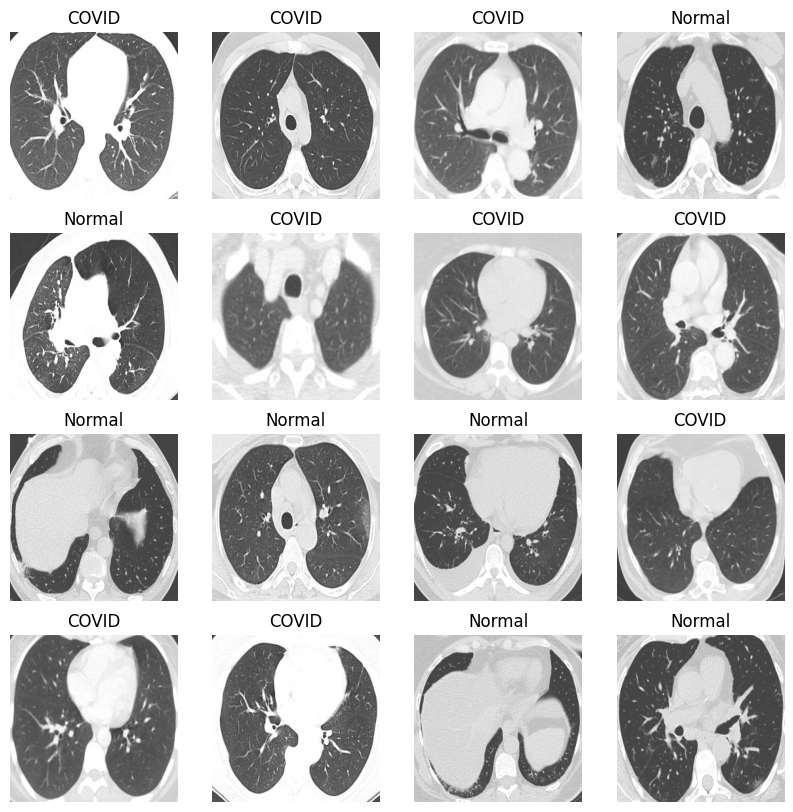

In [6]:
# Map the disease categories
mapping = {0:'Normal', 1:'COVID'}

# Initialize the training data augmentation object
trainAug = ImageDataGenerator(fill_mode="nearest")

# Randomly vizualize some augmented samples
plt.figure(figsize=(10,10))
for i, (image, label) in enumerate(trainAug.flow(X_train, y_train, batch_size=1)):
    if i == 16:
        break

    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(np.squeeze(image)/255.)
    plt.title(mapping[np.argmax(label[0])])
    plt.axis("off")

In [7]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Conv2D, Activation, Softmax, Multiply, Add

class DynamicContextualAttention(Layer):
    def __init__(self, filters, kernel_size, activation='relu', **kwargs):
        super(DynamicContextualAttention, self).__init__(**kwargs)
        self.filters = filters
        self.kernel_size = kernel_size
        self.activation = Activation(activation)
        
    def build(self, input_shape):
        self.conv_layer = Conv2D(self.filters, self.kernel_size, padding='same')
        self.conv_activation = self.activation
        self.conv_softmax = Softmax(axis=[1, 2])
        
        # Additional layers for temporal attention
        self.temporal_conv = Conv2D(1, (1, 1), padding='same')
        self.temporal_softmax = Softmax(axis=-1)
        
        self.adaptive_conv = Conv2D(1, (1, 1), padding='same')
        self.adaptive_activation = Activation('sigmoid')
        
        super(DynamicContextualAttention, self).build(input_shape)
    
    def call(self, inputs):
        # Spatial attention
        spatial_features = self.conv_activation(self.conv_layer(inputs))
        spatial_attention = self.conv_softmax(spatial_features)
        
        # Temporal attention
        temporal_features = self.temporal_conv(inputs)
        temporal_attention = self.temporal_softmax(temporal_features)
        
        # Hierarchical fusion
        attention_weights = Multiply()([spatial_attention, temporal_attention])
        
        # Adaptive attention refinement
        adaptive_weights = self.adaptive_activation(self.adaptive_conv(inputs))
        refined_attention = Add()([attention_weights, adaptive_weights])
        
        # Multiply attention maps with input
        attended_inputs = Multiply()([refined_attention, inputs])
        
        return attended_inputs
    
    def compute_output_shape(self, input_shape):
        return input_shape  # Output shape same as input shape
    
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'kernel_size': self.kernel_size,
            'activation': self.activation,
        })
        return config


In [8]:
def DCANModel(input_shape=(256, 256, 3), num_classes=2):
    # Input layer
    inputs = Input(shape=input_shape)
    
    # Base model (EfficientNetV2B0)
    base_model = EfficientNetV2B3(input_shape=input_shape, include_top=False, weights="imagenet")
    # We freeze our feature extractor
    base_model.trainable = True
    fmaps = base_model.output #base_model.get_layer('block4_pool').output
    dcan = DynamicContextualAttention(filters=fmaps.shape[-1], kernel_size=3)(fmaps)
    
    # Flatten layer
    gap = GlobalAveragePooling2D()(dcan)
    
    # Dense layer
    dense = Dense(64, activation='relu')(gap)
    
    # Output layer
    outputs = Dense(num_classes, activation='softmax')(dense)
    
    # Model
    model = Model(inputs=base_model.inputs, outputs=outputs)
    return model

In [9]:
# Create an instance of the CFNN model
model = DCANModel(image_size)

model.summary()

52606240/52606240 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 256, 256,  │          0 │ input_layer_1[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 256, 256,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 128, 128,  │      1,080 │ normalization[0]… │
│                     │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 128, 128,  │        160 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 128, 128,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 40)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 128, 128,  │      5,760 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 128, 128,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 128, 128,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_co… │ (None, 128, 128,  │      2,304 │ block1a_project_… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_bn  │ (None, 128, 128,  │         64 │ block1b_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_project_ac… │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_drop        │ (None, 128, 128,  │          0 │ block1b_project_… │
│ (Dropout)           │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1b_add (Add)   │ (None, 128, 128,  │          0 │ block1b_drop[0][… │
│                     │ 16)               │            │ block1a_project_… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 64, 64,    │      9,216 │ block1b_add[0][0] │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 64, 64,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 64, 64,    │          0 │ block2a_expand_b

 Total params: 13,029,120 (49.70 MB)

 Trainable params: 12,919,904 (49.29 MB)

 Non-trainable params: 109,216 (426.62 KB)

In [10]:
EPOCHS = 100
batch_size = 16
filepath = "/kaggle/working/COVID_DCAN.keras"

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

# Convert input data type to float32
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

# Define the necessary callbacks
checkpoint = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
earlystopping = EarlyStopping(monitor='val_accuracy', patience=15, verbose=1, mode='max', restore_best_weights=True)
rlrop = ReduceLROnPlateau(monitor='val_accuracy', mode='max', patience=5, factor=0.5, min_lr=1e-6, verbose=1)

callbacks = [checkpoint, rlrop] #earlystopping

print(f"[INFO] training network for {EPOCHS} epochs...\n")
hist = model.fit(X_train, y_train, batch_size=batch_size, validation_data=(X_test, y_test),epochs=EPOCHS, callbacks=callbacks)

[INFO] training network for 100 epochs...

Epoch 1/100


I0000 00:00:1718730444.701443     108 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1718730444.858983     108 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.8093 - loss: 0.4481

W0000 00:00:1718730468.890873     111 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Epoch 1: val_accuracy improved from -inf to 0.89738, saving model to /kaggle/working/COVID_DCAN.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 198s 286ms/step - accuracy: 0.8097 - loss: 0.4474 - val_accuracy: 0.8974 - val_loss: 0.2298 - learning_rate: 0.0010
Epoch 2/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.9099 - loss: 0.2023
Epoch 2: val_accuracy improved from 0.89738 to 0.94970, saving model to /kaggle/working/COVID_DCAN.keras
124/124 ━━━━━━━━━━━━━━━━━━━━ 19s 150ms/step - accuracy: 0.9100 - loss: 0.2022 - val_accuracy: 0.9497 - val_loss: 0.1420 - learning_rate: 0.0010
Epoch 3/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9205 - loss: 0.1845
Epoch 3: val_accuracy did not improve from 0.94970
124/124 ━━━━━━━━━━━━━━━━━━━━ 16s 127ms/step - accuracy: 0.9207 - loss: 0.1844 - val_accuracy: 0.9235 - val_loss: 0.2012 - learning_rate: 0.0010
Epoch 4/100
124/124 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step - accuracy: 0.9400 - loss: 0.1623
Epoch 4: val_accuracy improved from 0.949

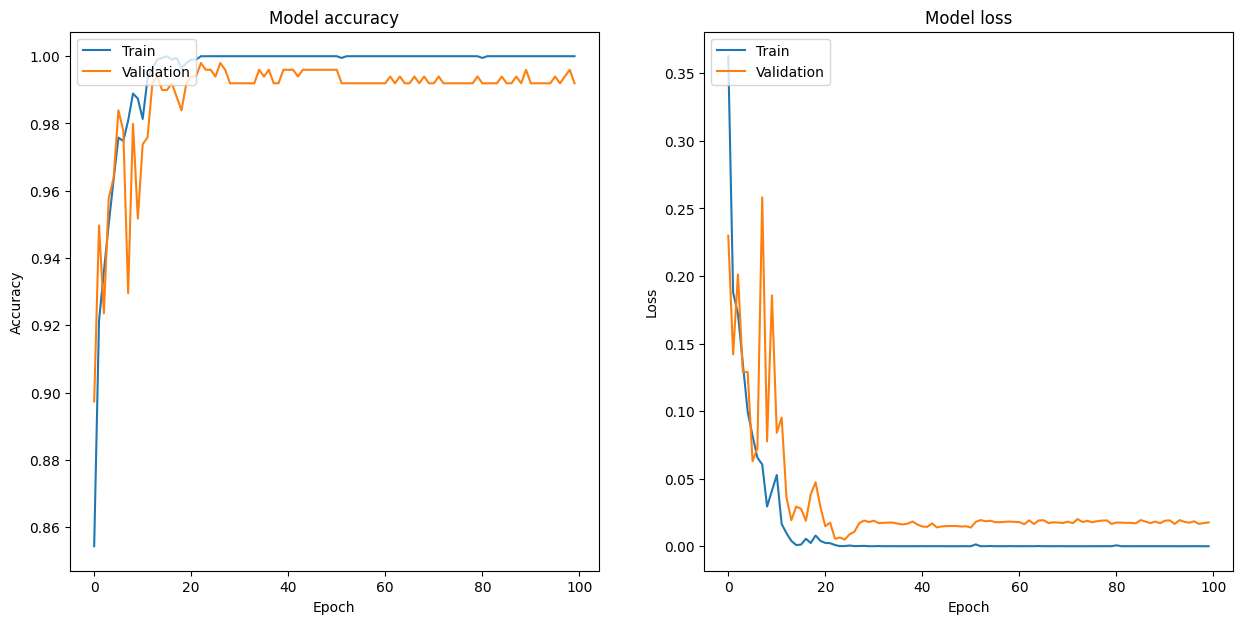

In [11]:
# Clear the values of previous plot
%matplotlib inline

fig = plt.figure(figsize=(15, 7))

# Plot training & validation accuracy values
fig.add_subplot(121)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Accuracy Plot')

# Plot training & validation loss values
fig.add_subplot(122)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.savefig('Training & Validation Loss Plot')

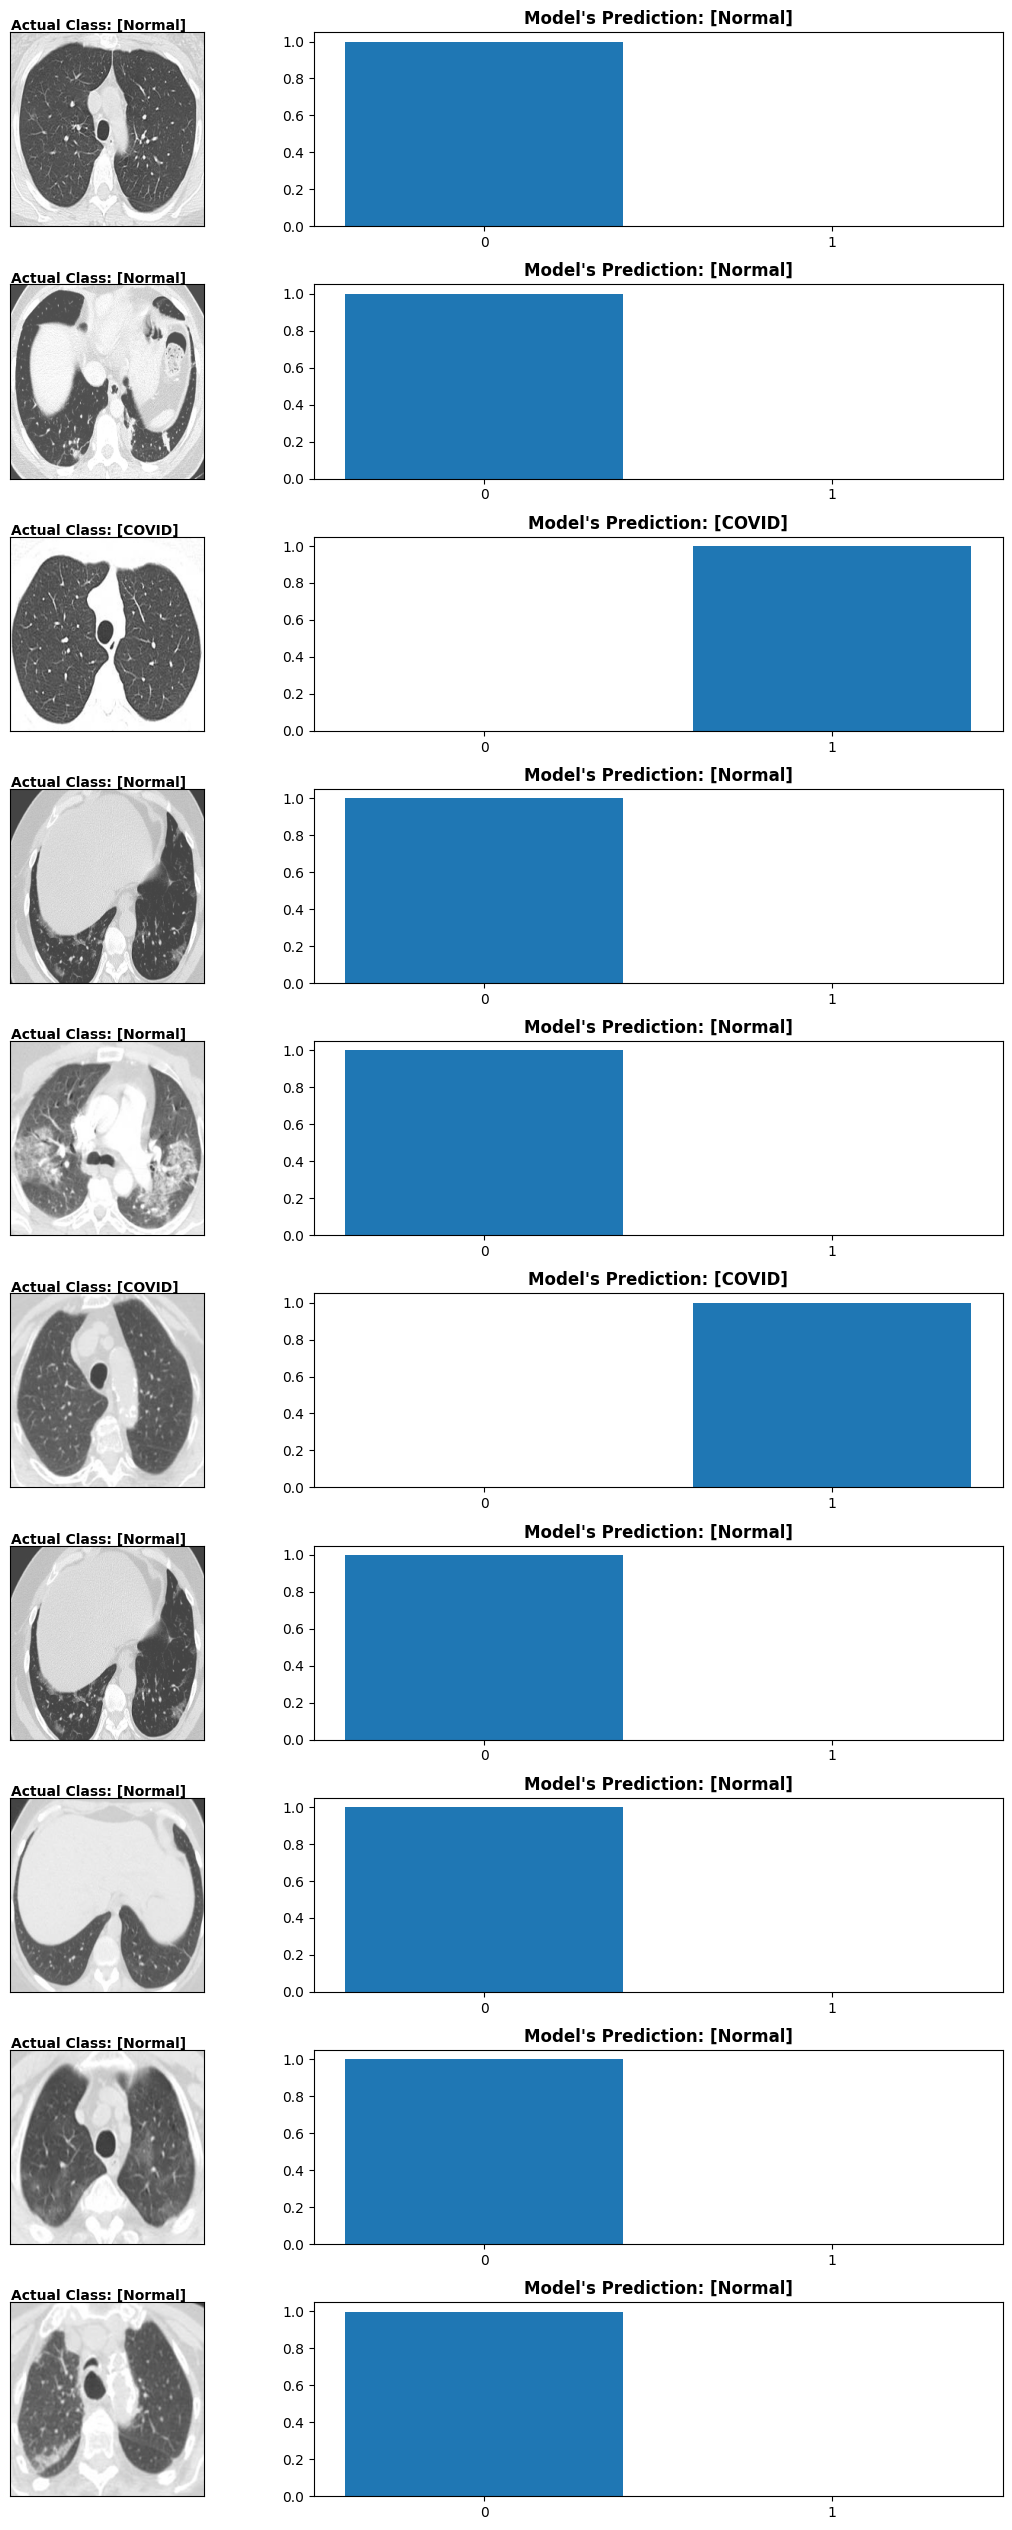

In [12]:
model.load_weights(filepath)

samples = np.random.choice(len(X_test), 10)
predictions = model.predict(X_test[samples], verbose=0)

fig, axes = plt.subplots(len(samples), 2, figsize=(16, 32))
fig.subplots_adjust(hspace=0.3, wspace=-0.2)

for i, (prediction, image, label) in enumerate(zip(predictions, X_test[samples], y_test[samples])):

    axes[i, 0].imshow(np.squeeze(image/255.))
    axes[i, 0].get_xaxis().set_visible(False)
    axes[i, 0].get_yaxis().set_visible(False)
    axes[i, 0].text(1., -3, f'Actual Class: [{mapping[np.argmax(label)]}]', weight='bold')

    axes[i, 1].bar(np.arange(len(prediction)), prediction)
    axes[i, 1].set_xticks(np.arange(len(prediction)))
    axes[i, 1].set_title(f"Model's Prediction: [{mapping[np.argmax(prediction)]}]", weight='bold')

In [13]:
y_score = model.predict(X_test)
y_pred = np.argmax(y_score,axis=-1)
Y_test = np.argmax(y_test,axis=-1)

16/16 ━━━━━━━━━━━━━━━━━━━━ 25s 677ms/step


In [14]:
from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score,cohen_kappa_score,roc_auc_score,confusion_matrix, classification_report

acc = accuracy_score(Y_test,y_pred)
mpre = precision_score(Y_test,y_pred,average='macro')
mrecall = recall_score(Y_test,y_pred,average='macro')
mf1 = f1_score(Y_test,y_pred,average='macro')
kappa = cohen_kappa_score(Y_test,y_pred,weights='quadratic')
#auc = roc_auc_score(Y_test, y_score, average='macro', multi_class='ovr')


print("Accuracy: ",round(acc*100,2))
print("Macro Precision: ",round(mpre*100,2))
print("Macro Recall: ",round(mrecall*100,2))
print("Macro F1-Score: ",round(mf1*100,2))
print("Quadratic Kappa Score: ",round(kappa*100,2))
#print("ROC AUC Score: ",round(auc*100,2))
print("\nConfusion Matrix: \n", confusion_matrix(Y_test,y_pred))
print("\nClassification Report:\n", classification_report(Y_test,y_pred, digits=4))

Accuracy:  99.8
Macro Precision:  99.8
Macro Recall:  99.8
Macro F1-Score:  99.8
Quadratic Kappa Score:  99.6

Confusion Matrix: 
 [[250   1]
 [  0 246]]

Classification Report:
               precision    recall  f1-score   support

           0     1.0000    0.9960    0.9980       251
           1     0.9960    1.0000    0.9980       246

    accuracy                         0.9980       497
   macro avg     0.9980    0.9980    0.9980       497
weighted avg     0.9980    0.9980    0.9980       497

